In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib ipympl
import matplotlib.animation
import matplotlib as mpl

import random
from PIL import Image, ImageDraw
import cv2
import numpy as np
import pandas as pd

from tifffile import imsave
from tqdm import tqdm

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from csbdeep.utils import Path, normalize

np.random.seed(42)
lbl_cmap = random_label_cmap()

# REFERENCE IMAGES FROM VIDEOS

In [ ]:
def grayscale_crop_and_resize(cap, frame, x1, y1, x2, y2, w, h):
	cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
	ret, image = cap.read()
	npImage = np.array(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
	npImage = npImage[y1:y2, x1:x2]
	return cv2.resize(npImage, (500, 500))

def get_frame(cap, frame, x1, y1, x2, y2, w, h):
	cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
	ret, image = cap.read()
	npImage = np.array(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
	alpha = Image.new('L', (w, h), 0)
	draw = ImageDraw.Draw(alpha)
	draw.pieslice(((x1, y1), (x2, y2)), 0, 360, fill=255)
	npAlpha = np.array(alpha)
	npImage = npImage*npAlpha
	ind = np.where(npImage == 0)
	npImage[ind] = npImage[200, 200]
	npImage = npImage[y1:y2, x1:x2]
	return cv2.resize(npImage, (500, 500))

In [ ]:
save_path = './training_dataset/'
nDrops = 50

source_path_25b25r = "./data/25b25r-1.mp4" 
xmin_25b25r, ymin_25b25r, xmax_25b25r, ymax_25b25r = 95, 30, 535, 470
video_25b25r = cv2.VideoCapture(source_path_25b25r)
video_25b25r.set(cv2.CAP_PROP_POS_FRAMES, 0)
w_25b25r = int(video_25b25r.get(cv2.CAP_PROP_FRAME_WIDTH))
h_25b25r = int(video_25b25r.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps_25b25r = int(video_25b25r.get(cv2.CAP_PROP_FPS))
n_frames_25b25r = int(video_25b25r.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"25b25r video has {n_frames_25b25r} frames with a resolution of {w_25b25r}x{h_25b25r} and a framerate of {fps_25b25r} fps")


source_path_49b1r  = "./data/49b1r.mp4"
xmin_49b1r,  ymin_49b1r,  xmax_49b1r,  ymax_49b1r  = 20, 50, 900, 930
nDrops_post_merge_49b1r = 49
video_49b1r = cv2.VideoCapture(source_path_49b1r)
video_49b1r.set(cv2.CAP_PROP_POS_FRAMES, 0)
w_49b1r = int(video_49b1r.get(cv2.CAP_PROP_FRAME_WIDTH))
h_49b1r = int(video_49b1r.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps_49b1r = int(video_49b1r.get(cv2.CAP_PROP_FPS))
n_frames_49b1r = int(video_49b1r.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"49b1r video has {n_frames_49b1r} frames with a resolution of {w_49b1r}x{h_49b1r} and a framerate of {fps_49b1r} fps")
print(f"25b25r video can be cropped to : {ymax_25b25r - ymin_25b25r, xmax_25b25r - xmin_25b25r}")
print(f"49b1r  video can be cropped to : {ymax_49b1r -  ymin_49b1r,  xmax_49b1r -  xmin_49b1r }")

start_49b1r = get_frame(video_49b1r, 0, xmin_49b1r, ymin_49b1r, xmax_49b1r, ymax_49b1r, w_49b1r, h_49b1r)
end_49b1r = get_frame(video_49b1r, n_frames_49b1r-1, xmin_49b1r, ymin_49b1r, xmax_49b1r, ymax_49b1r, w_49b1r, h_49b1r)
start_25b25r = get_frame(video_25b25r, 0, xmin_25b25r, ymin_25b25r, xmax_25b25r, ymax_25b25r, w_25b25r, h_25b25r)
end_25b25r = get_frame(video_25b25r, n_frames_25b25r-1, xmin_25b25r, ymin_25b25r, xmax_25b25r, ymax_25b25r, w_25b25r, h_25b25r)

fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0,0].imshow(start_49b1r, cmap='gray', vmin=0, vmax=255)
ax[0,0].set_title('Start 49b1r')
ax[0,1].imshow(end_49b1r, cmap='gray', vmin=0, vmax=255)
ax[0,1].set_title('End 49b1r')
ax[1,0].imshow(start_25b25r, cmap='gray', vmin=0, vmax=255)
ax[1,0].set_title('Start 25b25r')
ax[1,1].imshow(end_25b25r, cmap='gray', vmin=0, vmax=255)
ax[1,1].set_title('End 25b25r')
plt.tight_layout()
plt.show()
n_samples_49b1r  = 100
n_samples_25b25r = 100
n_samples = n_samples_49b1r + n_samples_25b25r

np.random.seed(0)
sample_frames_49b1r  = np.sort(np.array(random.sample(range(30000 ), n_samples_49b1r )), axis=0)
sample_frames_25b25r = np.sort(np.array(random.sample(range(n_frames_25b25r), n_samples_25b25r)), axis=0)

for frame in tqdm(sample_frames_49b1r):
    imsave(f"{save_path}49b1r/image/49b1r_frame{frame}.tif", get_frame(video_49b1r, frame, xmin_49b1r, ymin_49b1r, xmax_49b1r, ymax_49b1r, w_49b1r, h_49b1r))

for frame in tqdm(sample_frames_25b25r):
    imsave(f"{save_path}25b25r/image/25b25r_frame{frame}.tif", get_frame(video_25b25r, frame, xmin_25b25r, ymin_25b25r, xmax_25b25r, ymax_25b25r, w_25b25r, h_25b25r))

# SYNTHETIC DATASET FROM SIMULATION

In [148]:
# Function to check for collisions between droplets
def handle_droplet_collisions(pos, droplet_radius):
    r_ij_m = np.linalg.norm(pos[:, np.newaxis] - pos, axis=2)
    mask = np.tril(r_ij_m < 2 * droplet_radius, k=-1)
    r_ij = (pos[:, np.newaxis] - pos) * mask[:, :, np.newaxis]
    # Normalize displacements
    norms = np.linalg.norm(r_ij, axis=2)
    norms[norms == 0] = 1  # Avoid division by zero
    r_ij_v = r_ij / norms[:, :, np.newaxis]
    # Calculate adjustment factor
    adjustment = (2 * droplet_radius - r_ij_m) * mask
    # Apply adjustments to positions
    pos += np.sum(r_ij_v * (adjustment / 2)[:, :, np.newaxis], axis=1)
    pos -= np.sum(r_ij_v * (adjustment / 2)[:, :, np.newaxis], axis=0)

def handle_boundary_collisions(pos, outer_radius, droplet_radius):
    distances = np.linalg.norm(pos, axis=1)
    # Find indices where distances exceed the boundary
    out_of_boundary_mask = distances > outer_radius - droplet_radius
    # Calculate adjustment factor for positions exceeding the boundary
    adjustment = (outer_radius - droplet_radius) / distances[out_of_boundary_mask]
    # Apply adjustments to positions
    pos[out_of_boundary_mask] *= adjustment[:, np.newaxis]

def short_range_align(T0, pos, orientations, align_radius):
    T = np.zeros(pos.shape[0])
    for n in range(pos.shape[0]):
        v_n = np.array([np.cos(orientations[n]), np.sin(orientations[n])])
        r_ni = pos[n] - pos[np.arange(pos.shape[0])!=n]
        r_i = np.linalg.norm(r_ni, axis=1)
        S = np.where(r_i < align_radius)[0]
        T[n] = T0 * np.sum(np.divide(np.sum(v_n*r_ni[S], axis=1), r_i[S]**2) *\
                            np.cross(np.array([np.cos(orientations[n]), np.sin(orientations[n])]), r_ni[S]))
    return T

def handle_boundary_repulsion(positions, radius, repulsion_radius, repulsion_strength):
    distances = np.linalg.norm(positions, axis=1)
    # Find droplets too close to the boundary
    boundary_indices = distances > radius - repulsion_radius
    if np.any(boundary_indices):
        # Calculate repulsion force direction
        directions = - positions / distances[:, np.newaxis]
        forces = repulsion_strength / (distances ** 2)[:, np.newaxis]
        positions[boundary_indices] += forces[boundary_indices] * directions[boundary_indices]

In [221]:
# Constants
np.random.seed(0)

num_droplets = 50
time_steps = 10000
dt = 0.1 # time step size
droplet_radius = 10 # radius of the droplets
outer_radius = 250
v0_init = 10 # magnitude of the self-propulsion velocity
D_r = .2 # rotational diffusion coefficient
D_t = .2 # translational diffusion coefficient
time_constant = time_steps # time constant for the exponential decay of the self-propulsion velocity
T0 = 5  # magnitude of the short-range repulsion
align_radius = 5*droplet_radius  # radius for short-range alignment
repulsion_radius = outer_radius/4 #50
repulsion_strength = 10**5

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(range(time_steps), v0_init * np.exp(-np.array(range(time_steps)) / time_constant))
plt.close()

if 1:
    # Initialize droplet positions and orientations
    theta = np.random.uniform(0, 2 * np.pi, size = (num_droplets, 1))
    r = np.random.randint(0, outer_radius, size = (num_droplets, 1))
    positions = np.concatenate((r * np.cos(theta), r * np.sin(theta)), axis=1)
    #positions = np.random.uniform(-outer_radius + 30, outer_radius - 30, size=(num_droplets, 2))
    handle_droplet_collisions(positions, droplet_radius)
    orientations = np.random.uniform(0, 2*np.pi, size=num_droplets)

    frames, x, y, r, label = [], [], [], [], []

    for step in tqdm(range(time_steps)):
        # update magnitude of self-propulsion velocity
        v0 = v0_init * np.exp(-step / time_constant)
        # Update positions
        positions += v0 * np.array([np.cos(orientations), np.sin(orientations)]).T * dt + \
                        np.random.normal(scale=np.sqrt(2 * D_t * dt), size=(num_droplets, 2))

        # Handle collisions with the boundary and between droplets
        handle_droplet_collisions(positions, droplet_radius)
        handle_boundary_collisions(positions, outer_radius, droplet_radius)
        handle_boundary_repulsion(positions, outer_radius, repulsion_radius, repulsion_strength)

        # Update orientations with rotational diffusion and short-range alignment
        short_range_align(T0, positions, orientations, align_radius)
        orientations += np.random.normal(scale=np.sqrt(2 * D_r * dt), size=num_droplets)

        # Ensure orientations stay within [0, 2*pi)
        orientations %= 2 * np.pi

        frames += [step for i in range(num_droplets)]
        x += list(positions[:, 0])
        y += list(positions[:, 1])
        r += [droplet_radius for i in range(num_droplets)]
        label += [i for i in range(num_droplets)]
        
    trajectories = pd.DataFrame({'frame': frames, 'x': x, 'y': y, 'r': r, 'label': label})
    trajectories.to_parquet('trajectories_simulate_test.parquet')

100%|██████████| 10000/10000 [01:33<00:00, 107.21it/s]


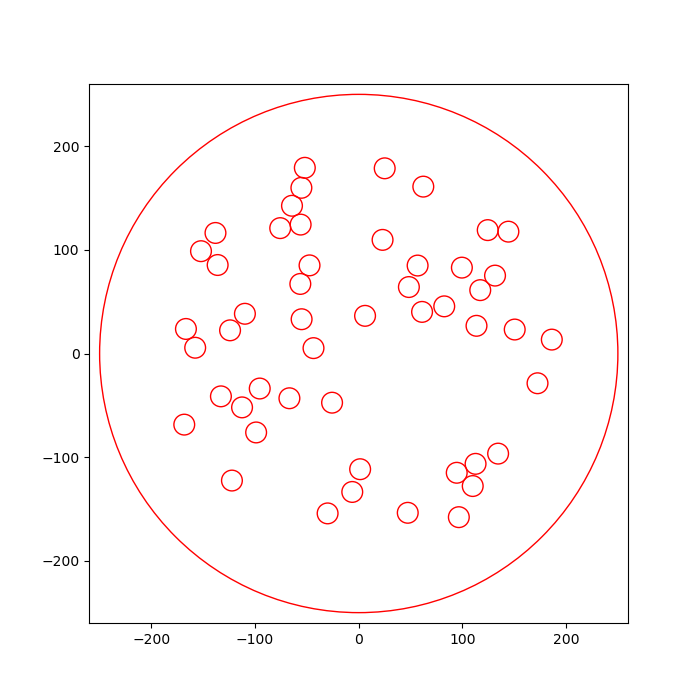

In [222]:
distances = np.linalg.norm(positions, axis=1)
# Find droplets too close to the boundary
boundary_indices = distances > outer_radius - repulsion_radius
directions = - positions / distances[:, np.newaxis]
forces = repulsion_strength / (distances ** 2)[:, np.newaxis]
test_pos = positions[boundary_indices]

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
for i in range(test_pos.shape[0]):
    ax.add_artist(plt.Circle((test_pos[i, 0], test_pos[i, 1]), droplet_radius, color='b', alpha=0.5))

for i in range(num_droplets):
    ax.add_artist(plt.Circle((positions[i, 0], positions[i, 1]), droplet_radius, color='r', fill = False))
ax.add_artist(plt.Circle((0, 0), outer_radius, color='r', fill=False))
ax.quiver(test_pos[:, 0], test_pos[:, 1], directions[boundary_indices, 0], directions[boundary_indices, 1], color='b', scale=forces[boundary_indices].reshape(-1)*100000000000)
ax.set_xlim(-outer_radius - 10, outer_radius + 10)
ax.set_ylim(-outer_radius - 10, outer_radius + 10)
ax.set_aspect('equal')
plt.show()

In [157]:
fig = plt.figure(figsize = (8, 8))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True
        
def update_graph(frame):
    df = trajectories.loc[(trajectories.frame == frame), ["x", "y", "r"]]
    for i in range(len(df)):
        graph[i].center = (df.x.values[i], df.y.values[i])
        graph[i].radius = df.r.values[i]
    title.set_text(f'Tracking -- step = {frame} ')
    return graph

ax = fig.add_subplot(111)
title = ax.set_title(f'Tracking -- step = {0} ')
ax.set(xlabel = 'X [px]', ylabel = 'Y [px]')
df = trajectories.loc[(trajectories.frame == 0), ["x", "y", "r"]]

graph = []
for i in range(len(df)):
    graph.append(ax.add_artist(plt.Circle((df.x.values[i], df.y.values[i]), df.r.values[i], fill = True, alpha = 0.5, color = 'b')))
ax.add_artist(plt.Circle((0, 0), outer_radius, color='r', fill=False))
ax.set_xlim(-outer_radius, outer_radius)
ax.set_ylim(-outer_radius, outer_radius)

fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, range(0, time_steps, 10), interval = 5, blit=False)
writer = matplotlib.animation.FFMpegWriter(fps = 30, metadata = dict(artist='Matteo Scandola'), extra_args=['-vcodec', 'libx264'])
ani.save(f'./test.mp4', writer=writer)
plt.close()

# SYNTHETIC DATASET GENERATOR

In [159]:
def get_frame(cap, frame, x1, y1, x2, y2, w, h):
	cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
	ret, image = cap.read()
	npImage = np.array(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
	alpha = Image.new('L', (w, h), 0)
	draw = ImageDraw.Draw(alpha)
	draw.pieslice(((x1, y1), (x2, y2)), 0, 360, fill=255)
	npAlpha = np.array(alpha)
	npImage = npImage*npAlpha
	ind = np.where(npImage == 0)
	npImage[ind] = npImage[200, 200]
	npImage = npImage[y1:y2, x1:x2]
	npImage = cv2.resize(npImage, (500, 500))
	return npImage

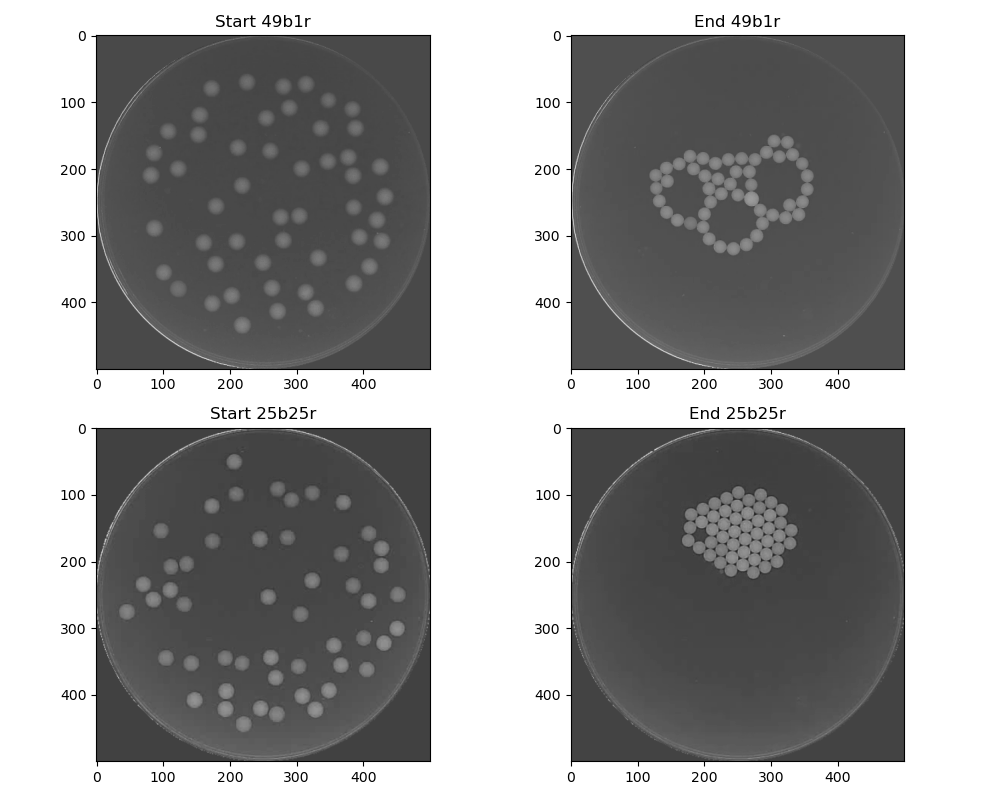

In [160]:
source_path_25b25r = "./data/25b25r-1.mp4" 
xmin_25b25r, ymin_25b25r, xmax_25b25r, ymax_25b25r = 95, 30, 535, 470
video_25b25r = cv2.VideoCapture(source_path_25b25r)
video_25b25r.set(cv2.CAP_PROP_POS_FRAMES, 0)
w_25b25r = int(video_25b25r.get(cv2.CAP_PROP_FRAME_WIDTH))
h_25b25r = int(video_25b25r.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps_25b25r = int(video_25b25r.get(cv2.CAP_PROP_FPS))
n_frames_25b25r = int(video_25b25r.get(cv2.CAP_PROP_FRAME_COUNT))


source_path_49b1r  = "./data/49b1r.mp4"
xmin_49b1r,  ymin_49b1r,  xmax_49b1r,  ymax_49b1r  = 20, 50, 900, 930
video_49b1r = cv2.VideoCapture(source_path_49b1r)
video_49b1r.set(cv2.CAP_PROP_POS_FRAMES, 0)
w_49b1r = int(video_49b1r.get(cv2.CAP_PROP_FRAME_WIDTH))
h_49b1r = int(video_49b1r.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps_49b1r = int(video_49b1r.get(cv2.CAP_PROP_FPS))
n_frames_49b1r = int(video_49b1r.get(cv2.CAP_PROP_FRAME_COUNT))

start_49b1r = get_frame(video_49b1r, 0, xmin_49b1r, ymin_49b1r, xmax_49b1r, ymax_49b1r, w_49b1r, h_49b1r)
end_49b1r = get_frame(video_49b1r, n_frames_49b1r-1, xmin_49b1r, ymin_49b1r, xmax_49b1r, ymax_49b1r, w_49b1r, h_49b1r)
start_25b25r = get_frame(video_25b25r, 0, xmin_25b25r, ymin_25b25r, xmax_25b25r, ymax_25b25r, w_25b25r, h_25b25r)
end_25b25r = get_frame(video_25b25r, n_frames_25b25r-1, xmin_25b25r, ymin_25b25r, xmax_25b25r, ymax_25b25r, w_25b25r, h_25b25r)

fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0,0].imshow(start_49b1r, cmap='gray', vmin=0, vmax=255)
ax[0,0].set_title('Start 49b1r')
ax[0,1].imshow(end_49b1r, cmap='gray', vmin=0, vmax=255)
ax[0,1].set_title('End 49b1r')
ax[1,0].imshow(start_25b25r, cmap='gray', vmin=0, vmax=255)
ax[1,0].set_title('Start 25b25r')
ax[1,1].imshow(end_25b25r, cmap='gray', vmin=0, vmax=255)
ax[1,1].set_title('End 25b25r')
plt.tight_layout()
plt.show()

In [287]:
def overlap_between_circles(existing_circles, center, radius, min_distance):
    for existing_center in existing_circles:
        distance = np.linalg.norm(np.array(existing_center[0]) - np.array(center))
        if distance < radius + existing_center[1]:
            return True
    return False

def create_gaussian(center, img_width, img_height, sigma, ampl):
    center_x, center_y = center
    x = np.linspace(0, img_width-1, img_width)
    y = np.linspace(0, img_height-1, img_height)
    X, Y = np.meshgrid(x, y)
    gaussian = np.exp(-((X-center_x)**2 + (Y-center_y)**2) / (2.0 * sigma**2))
    return np.round(ampl*(gaussian / np.max(gaussian))).astype(np.uint8)

def generate_synthetic_image(outer_radius, n_feature, height, width, rmin, rmax, color, gaussian_sigma, gaussian_amplitude, sharp_verb=False):
    # create background image
    image = np.random.randint(65, 75, (height, width), dtype=np.uint8)
    # initialize mask
    mask = np.zeros((height, width), dtype=np.uint8)
    list_of_centers = []
    list_of_distances = []

    for i in range(n_feature):
        while True:
            # Generate a random position inside the outer circle 
            theta = random.uniform(0, 2 * np.pi)
            r = random.randint(0, outer_radius)
            center = (int(width/2 + r * np.cos(theta)), int(height/2 + r * np.sin(theta)))

            feature_radius = random.randint(rmin, rmax)

            if not overlap_between_circles(list_of_centers, center, feature_radius, feature_radius):
                list_of_centers.append([center, feature_radius])
                break
        #color = 110 #(random.randint(0, 255))
        index = i + 1  # Assign unique index (starting from 1)
        # Draw the circle on the image 
        # lineType = 4 for 4-connected line, 8 for 8-connected line, LINE_AA for antialiased line
        cv2.circle(image, center, feature_radius, color, -1, lineType=4) 

        # draw circles as gaussian distribution
        cv2.add(image, create_gaussian(center, width, height, gaussian_sigma, gaussian_amplitude))

        # Draw the circle with its index on the mask
        #draw_circle_with_index(mask, center, feature_radius, index)
        cv2.circle(mask, center, feature_radius, (index), -1)
        
    # Draw the outer circle mimicking the petri dish
    cv2.circle(image, (int(height/2), int(width/2)), int(width/2), 150) 
    cv2.circle(image, (int(height/2), int(width/2)), int(width/2)-4, 150) 
    if sharp_verb:
        kernel = np.array([[0, -1, 0],
                        [-1, 5,-1],
                        [0, -1, 0]])
        image = cv2.filter2D(image, ddepth=-1, kernel=kernel)
    image = cv2.GaussianBlur(image, (5, 5), 2)
    return image, mask


def generate_synthetic_image_from_simulation_data(trajectories, outer_radius, frame, height, width, gaussian_sigma, gaussian_amplitude, color, sharp_verb=False):
    trajs = trajectories.loc[(trajectories.frame == frame), ["x", "y", "r"]]
    # create background image
    image = np.random.randint(70, 75, (height, width), dtype=np.uint8)
    # Draw the outer circle mimicking the petri dish
    cv2.circle(image, (int(height/2), int(width/2)), int(width/2), 150) 
    cv2.circle(image, (int(height/2), int(width/2)), int(width/2)-4, 150) 
    
    image = cv2.GaussianBlur(image, (5, 5), 4)
    
    
    # initialize mask
    mask = np.zeros((height, width), dtype=np.uint8)
    list_of_centers = []
    circles_array = np.zeros((height, width), dtype=np.uint8)
    list_of_distances = []
    for i in range(len(trajs)):
        index = i + 1 
        center = (int(width/2 + trajs.x.values[i]), int(height/2 + trajs.y.values[i]))
        feature_radius = int(trajs.r.values[i])
        cv2.circle(image, center, feature_radius, color, -1, lineType=8) 
        #cv2.add(image, create_gaussian(center, width, height, gaussian_sigma, gaussian_amplitude))
        circles_array += create_gaussian(center, width, height, gaussian_sigma, gaussian_amplitude)
        cv2.circle(mask, center, feature_radius, (index), -1)
    
    
    if sharp_verb:
        image = cv2.GaussianBlur(image, (5, 5), 2)
        kernel = np.array([[0, -1, 0],
                        [-1, 5,-1],
                        [0, -1, 0]])
        image = cv2.filter2D(image, ddepth=-1, kernel=kernel)
    
    image += circles_array 
    return image, mask, circles_array

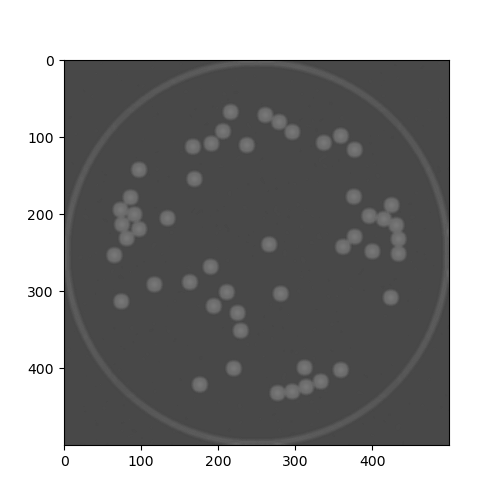

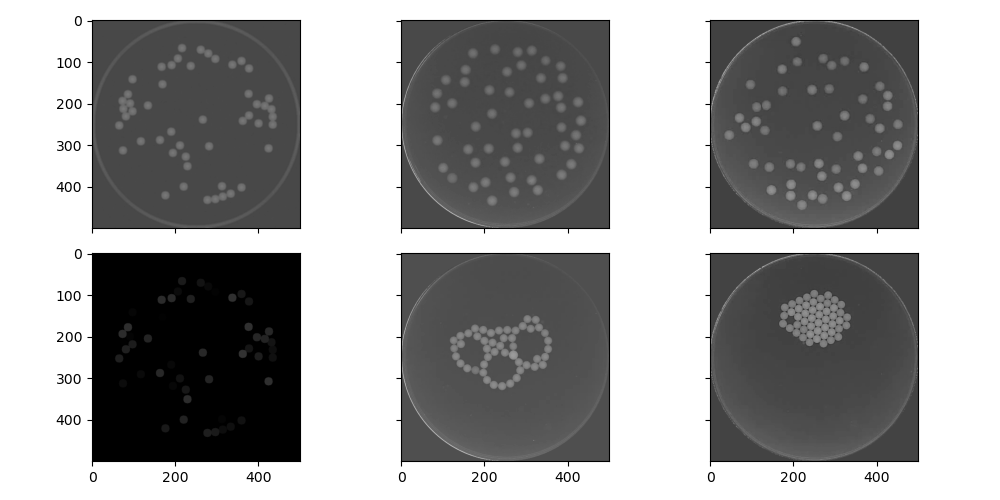

In [288]:
if 0:
    test_img, test_mask = generate_synthetic_image(outer_radius=100, n_feature=50, height=500,\
                                               width=500, rmin=10, rmax=10, color=110, gaussian_sigma=20,\
                                               gaussian_amplitude=10, sharp_verb=True) 

test_img, test_mask, circles_array = generate_synthetic_image_from_simulation_data(trajectories=trajectories, outer_radius=100,\
                                                                                   frame=1000, height=500, width=500, gaussian_sigma=5,\
                                                                                   gaussian_amplitude=20, color=100, sharp_verb=True)

fig, ax = plt.subplots(1, 1, figsize = (5, 5))
ax.imshow(test_img, cmap="gray", vmin=0, vmax=255)
plt.show()

if 1:
    fig, axs = plt.subplots(2, 3, figsize=(10, 5), sharex=True, sharey=True)
    axs[0,0].imshow(test_img, cmap="gray", vmin=0, vmax=255)
    axs[0,1].imshow(start_49b1r, cmap='gray', vmin=0, vmax=255)
    axs[0,2].imshow(start_25b25r, cmap='gray', vmin=0, vmax=255)
    axs[1,0].imshow(test_mask, cmap='gray', vmin=0, vmax=255)
    axs[1,1].imshow(end_49b1r, cmap='gray', vmin=0, vmax=255)
    axs[1,2].imshow(end_25b25r, cmap='gray', vmin=0, vmax=255)
    #axs[1,0].hist(test_img.flatten(), bins=256, range=(0, 255), density=True)
    #axs[1,1].hist(start_49b1r.flatten(), bins=256, range=(0, 255), density=True)
    #axs[1,2].hist(start_25b25r.flatten(), bins=256, range=(0, 255), density=True)
    plt.tight_layout()
    plt.show()

In [286]:
trajectories.frame.unique()

array([   0,    1,    2, ..., 9997, 9998, 9999])

In [290]:
sample_frames = trajectories.frame.unique()[::10]
test_img = np.zeros((len(sample_frames), 500, 500), dtype=np.uint8)
test_mask = np.zeros((len(sample_frames), 500, 500), dtype=np.uint8)
count = 0

for frame in tqdm(sample_frames):
    test_img[count], test_mask[count], _ = generate_synthetic_image_from_simulation_data(trajectories=trajectories, outer_radius=100,\
                                                                            frame=frame, height=500, width=500, gaussian_sigma=5,\
                                                                            gaussian_amplitude=20, color=100, sharp_verb=True)
    count += 1

100%|██████████| 1000/1000 [06:48<00:00,  2.45it/s]


In [293]:
fig = plt.figure(figsize = (8, 8))
def update_graph(frame):
    graph.set_data(test_img[frame])
    title.set_text(f'Tracking -- frame = {sample_frames[frame]}')
    return graph

ax = fig.add_subplot(111)
title = ax.set_title(f'Tracking -- frame = {0}')
ax.set(xlabel = 'X [px]', ylabel = 'Y [px]')
graph = ax.imshow(test_img[0], cmap='gray', vmin=0, vmax=255)

ani = matplotlib.animation.FuncAnimation(fig, update_graph, range(test_img.shape[0]), interval = 5, blit=False)
writer = matplotlib.animation.FFMpegWriter(fps = 30, metadata = dict(artist='Matteo Scandola'), extra_args=['-vcodec', 'libx264'])
ani.save(f'simulation_video.mp4', writer=writer)
plt.close()

In [ ]:
for i in tqdm(range(1000)):
    img, mask = generate_synthetic_image()
    imsave(f'./synthetic_dataset/image/synthetic_image_{i}.tif', img)
    imsave(f'./synthetic_dataset/mask/synthetic_mask_{i}.tif', mask)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_aug, cmap='gray', vmin=0, vmax=255)
ax[0].set_title('Augmented Image')
ax[1].imshow(lbl_aug, cmap='gray')
ax[1].set_title('Augmented Mask')
plt.tight_layout()
plt.show()

# HOUGH-CIRCLE DATASET GENERATOR

## FROM DATA OF 49b-1r HOUGH CIRCLE METHOD DETECTION

In [ ]:
def get_frame(cap, frame, x1, y1, x2, y2, w, h, preprocess):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
    ret, image = cap.read()
    if preprocess:
        npImage = np.array(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
        alpha = Image.new('L', (w, h), 0)
        draw = ImageDraw.Draw(alpha)
        draw.pieslice(((x1, y1), (x2, y2)), 0, 360, fill=255)
        npAlpha = np.array(alpha)
        npImage = npImage*npAlpha
        ind = np.where(npImage == 0)
        npImage[ind] = npImage[200, 200]
        npImage = npImage[y1:y2, x1:x2]
        return npImage
    elif not preprocess:
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        raise ValueError("preprocess must be a boolean")

In [ ]:
trajectories = pd.read_parquet('./49b_1r/old/tracking_data/hough/tracking_hough_trackpy_linking.parquet')
# rename column to be consistent with the other datasets
trajectories.rename(columns={'d':'r'}, inplace=True)
# remove rows with NaN values in the radius column
trajectories.dropna(subset=['r'], inplace=True)
display(trajectories.head())

In [ ]:
video = cv2.VideoCapture('/Users/matteoscandola/MasterThesis/tracking/data/49b1r.mp4')
video.set(cv2.CAP_PROP_POS_FRAMES, 0)
_, first_frame = video.read()

In [ ]:
# sample x frames from the hough-method tracking dataset
n_samples = 1000
np.random.seed(42)
sample_frames = np.sort(np.random.choice(trajectories.frame.unique().astype(int), size=n_samples, replace=False))

for frame in tqdm(sample_frames):
    frame_img = get_frame(video, frame, 55, 55, 880, 880, 920, 960, True)
    imsave(f"/Users/matteoscandola/MasterThesis/tracking/train_49b-1r/image/49b1r_frame{frame}.tif", frame_img)
    df = trajectories.loc[(trajectories.frame == frame), ["x", "y", "r"]]
    image = np.zeros((880 - 55, 880 - 55), dtype=np.uint8)
    count = 0
    for _, droplet in df.iterrows():
        x, y, radius = droplet['x'], droplet['y'], droplet['r']
        cv2.circle(image, (int(x)- 55, int(y) - 55), int(radius), int(count), thickness=-1)
        count += 1
    imsave(f"/Users/matteoscandola/MasterThesis/tracking/train_49b-1r/mask/49b1r_frame{frame}.tif", image)    

## GENERATING NEW HOUGH CIRCLE DETECTIONS

In [ ]:
def get_frame_hough(cap, frame, x1, y1, x2, y2, w, h):
	cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
	ret, image = cap.read()
	npImage = np.array(image)
	alpha = Image.new('L', (w, h), 0)
	draw = ImageDraw.Draw(alpha)
	draw.pieslice(((x1, y1), (x2, y2)), 0, 360, fill=255)
	npAlpha = np.array(alpha)
	npImage = cv2.cvtColor(npImage, cv2.COLOR_BGR2GRAY)*npAlpha 
	ind = np.where(npImage == 0)
	npImage[ind] = npImage[200, 200]
	npImage = npImage[y1:y2, x1:x2]
	return npImage 
	
def hough_loc_frame(correct_n, frame, img, parameters):
	found_circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT_ALT, **parameters)
	if found_circles is not None:
		return np.hstack((found_circles[0], (np.ones((found_circles.shape[1], 1), dtype=int)*frame),\
							np.ones((found_circles.shape[1], 1), dtype=int)*found_circles.shape[1]))
	else:
		return np.hstack((np.ones((1, 3))*-1, np.array([[frame, 0]])))
		
def hough_feature_location(sample_frames, correct_n, params):
	temp = []
	for frame in tqdm(sample_frames):
		img = get_frame_hough(video, frame, xmin, ymin, xmax, ymax, w, h)
		temp.append(hough_loc_frame(correct_n, frame, img, params))
	
	temp_df = pd.DataFrame(np.concatenate([arr for arr in temp]), columns = ["x", "y", "d", "frame", "nDroplets"])
	temp_df["frame"] = temp_df["frame"].astype(int)
	temp_df["nDroplets"] = temp_df["nDroplets"].astype(int)
	err_frames = temp_df.loc[temp_df.nDroplets != correct_n].frame.unique().astype(int)
	loss = err_frames.shape[0]/sample_frames.shape[0]
	return temp_df, err_frames, loss

def optimize_params(x, *args):
	frames, correct_n = args
	params = {"dp":x[0], "minDist":int(x[1]), "param1":x[2], "param2":x[3], "minRadius":int(x[4]), "maxRadius":int(x[5])}
	errs = 0
	for i in tqdm(frames):
		img = get_frame_hough(video, i, xmin, ymin, xmax, ymax, w, h)
		found_circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT_ALT, **params)
		if (found_circles is not None) and (found_circles.shape[1] == correct_n):
			pass
		else:
			errs += 1
			
	loss = errs/frames.shape[0]
	a = [loss, x[0], int(x[1]), x[2], x[3], int(x[4]), int(x[5])]
	print(a)
	return loss

In [ ]:
n_samples = 100
random.seed(0)
sample_frames = np.sort(np.array(random.sample(range(n_frames), n_samples)), axis=0)

test_params = {"dp":1.5, "minDist":10, "param1":20, "param2":0.7, "minRadius":5, "maxRadius":30}

temp_df, err_frames, loss = hough_feature_location(sample_frames, nDrops, test_params)
print(loss, err_frames)
temp_df_test = temp_df.loc[temp_df.frame == err_frames[1]]
test_img = get_frame_hough(video, err_frames[1], xmin, ymin, xmax, ymax, w, h)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(test_img, cmap="gray")
for i in range(temp_df_test.nDroplets.iloc[0]):
    circle = plt.Circle((temp_df_test.x.iloc[i], temp_df_test.y.iloc[i]), temp_df_test.d.iloc[i], color='r', fill=True, alpha=0.5)
    ax.add_artist(circle)
ax.set(xticks=[], yticks=[], title=f"Frame {err_frames[1]} -- {temp_df_test.nDroplets.iloc[0]} droplets")
plt.show()

In [ ]:
# paramters of HoughCircles --> dp, minDist, param1, param2, minRadius, maxRadius
init_guess =  [2, 5, 20, 0.7, 7, 12] # initial guess for the parameters
params_bounds = [(1, 3), (1, 10), (1, 100), (0.3, 1), (5, 10), (10, 15)] # bounds for the parameters

opt_result = dual_annealing(optimize_params, x0 = init_guess, args = (sample_frames, nDrops), bounds = params_bounds, maxiter = 2000)